## Process SODA data before creating lateral forcing

The SODA3.4.2 data is downloaded from: http://www.soda.umd.edu/soda4_readme.htm (https://dsrs.atmos.umd.edu/DATA/soda3.4.2/REGRIDED/ocean/)

The data covers the period 1980 to 2020 and has a resolution of 0.5°x0.5°x50vel Mercator grid




For the lateral forcing notebook to succesfully work the data should have dimensions: depth, time, longitude, latitude

Make sure all variables have the same units and only SSH, S, T, U&V are used

The SSH field should be corrected for the global mean





The ocean files contain seven two dimensional fields:

- ssh [= sea level + Pa/(rho0*g)]: MOM5 computes sea level from a complete conservation of mass equation (MOM5_elements.pdf section 38.2). This means sea level includes both steric (changes in column density) effects and eustatic (changes in column mass) effects. Currently SODA3 does not add mass due to continental ice melt, and does not include the impact of self-gravitation. Also note that the ocean bottom elevation in MOM5 is fixed and thus we do not include the effects of glacial isostatic adjustment or ocean loading.

The ocean files also contain six three dimensional fields specified at the depths listed above.

- temp: potential temperature [°C]
- salt: SODA3 treats salinity as practical salinity (PSS-78) as expressed in Practical Salinity Units [psu]. The model uses preformed salinity as its salinity state variable and uses the TEOS10 equation of state. Absolute salinity is, on average, 0.4% larger than practical salinity.
- {u,v,w}: horizontal and vertical components of velicity. w is computed diagnostically from conservation of mass and is evaluated on a different grid. [m/s]
- prho: potential density computed from potential temperature, practical salinity, and pressure using the TEOS-10 formulas. [kg/m^3]




In this Notebook:
- Raw, downloaded data is imported
- SSH signal is corrected for global mean
- Longitudes are changed from [0, 360] to [-180, 180] 
- Unnecessary variables are dropped
- ROMS area is selected
- New dataset is created. Original data is 150GB, saved data is 1.22GB
- A test dataset with only 3 time steps is created

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

In [2]:
soda_in = xr.open_mfdataset('/projects/0/einf2878/ROMS/data/SODA/raw/*.nc')
soda = soda_in

## Obtain weighted global mean SSH

In [3]:
weights = np.cos(np.deg2rad(soda.yt_ocean))
soda_weighted = soda.weighted(weights)

soda_global = soda_weighted.mean(['xt_ocean', 'yt_ocean'])

Text(0.5, 1.0, 'SODA globally averaged monthly SSH')

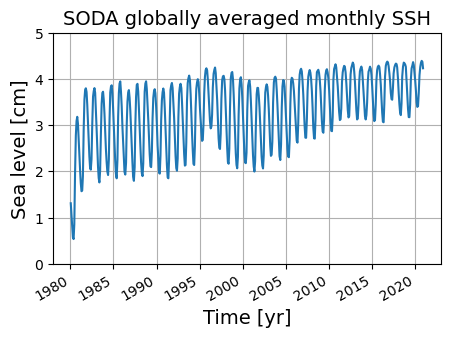

In [5]:
plt.figure(figsize = (5,3))
soda_global_cm = soda_global.ssh*100
soda_global_cm.plot()
plt.grid()
plt.ylim([0, 5])
plt.xlabel('Time [yr]', fontsize = 14)
plt.ylabel('Sea level [cm]', fontsize = 14)
plt.title('SODA globally averaged monthly SSH', fontsize = 14)

Text(0.5, 1.0, 'SODA globally averaged annual SSH')

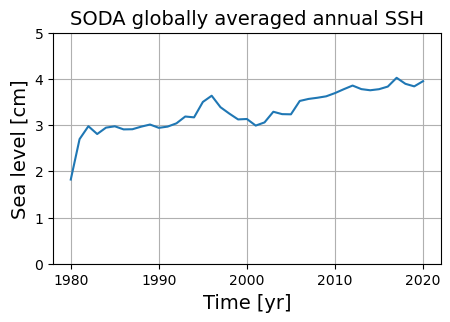

In [6]:
plt.figure(figsize = (5,3))
global_ssh_year = soda_global.ssh.groupby(soda.time.dt.year).mean('time')*100
global_ssh_year.plot()
plt.grid()
plt.ylim([0, 5])
plt.xlabel('Time [yr]', fontsize = 14)
plt.ylabel('Sea level [cm]', fontsize = 14)
plt.xticks([1980, 1990, 2000, 2010, 2020])
plt.title('SODA globally averaged annual SSH', fontsize = 14)

In [7]:
# Remove global SSH from soda sea-level signal

soda['ssh'] = soda['ssh'] - soda_global.ssh

## Change longitude values from [0, 360] to [-180, 180]

In [8]:
xt_newvalues = list(np.arange(0.25, 180, 0.5)) + list(np.arange(-179.75, 0, 0.5))
xu_newvalues = list(np.arange(0.5, 180, 0.5)) + list(np.arange(-180, 0.5, 0.5))

In [9]:
soda['xt_ocean'] = xt_newvalues
soda['xu_ocean'] = xu_newvalues

soda = soda.sortby(['xt_ocean', 'xu_ocean'])

/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/

## Drop unnecessary variables

In [10]:
soda = soda.drop(['wt', 'mlt', 'mlp', 'mls', 'net_heating', 'prho', 'taux', 'tauy', 'sw_ocean'])

## Split dataset

In [11]:
soda_t = soda.drop(['u', 'v', 'xu_ocean', 'yu_ocean'])
soda_u = soda.drop(['temp', 'salt', 'ssh', 'xt_ocean', 'yt_ocean'])

## Select ROMS area

In [12]:
soda_t = soda_t.where((soda.xt_ocean > -20) & (soda.xt_ocean < 10) & (soda.yt_ocean > 36) & (soda.yt_ocean < 62), drop = True)
soda_u = soda_u.where((soda.xu_ocean > -20) & (soda.xu_ocean < 10) & (soda.yu_ocean > 36) & (soda.yu_ocean < 62), drop = True)

/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/home/ikeizer/.conda/envs/py39/lib/python3.10/site-packages/xarray/core/indexing.py:1233: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  val

## Create new dataset

In [13]:
data_vars = dict(thetao=(['time', 'depth', 'yt_ocean', 'xt_ocean'], soda_t.temp.values, soda_t.temp.attrs),
                so=(['time', 'depth', 'yt_ocean', 'xt_ocean'], soda_t.salt.values, soda_t.salt.attrs),
                zos=(['time', 'yt_ocean', 'xt_ocean'], soda_t.ssh.values, soda_t.ssh.attrs),
                uo=(['time', 'depth', 'yu_ocean', 'xu_ocean'], soda_u.u.values, soda_u.u.attrs),
                vo=(['time', 'depth', 'yu_ocean', 'xu_ocean'], soda_u.v.values, soda_u.v.attrs),)



coords = dict(time=(['time'], soda_t.time.values, soda_t.time.attrs),
             depth=(['depth'], soda_t.st_ocean.values, soda_t.st_ocean.attrs),
             xt_ocean=(['xt_ocean'], soda_t.xt_ocean.values, soda_t.xt_ocean.attrs),
             yt_ocean=(['yt_ocean'], soda_t.yt_ocean.values, soda_t.yt_ocean.attrs),
             xu_ocean=(['xu_ocean'], soda_u.xu_ocean.values, soda_u.xu_ocean.attrs),
             yu_ocean=(['yu_ocean'], soda_u.yu_ocean.values, soda_u.yu_ocean.attrs))





soda_out = xr.Dataset(data_vars=data_vars,
                      coords=coords,
                     attrs=soda_in.attrs)





## Save processed dataset

In [14]:
soda_out.to_netcdf('/projects/0/einf2878/ROMS/data/SODA/forcing_input/soda.nc')

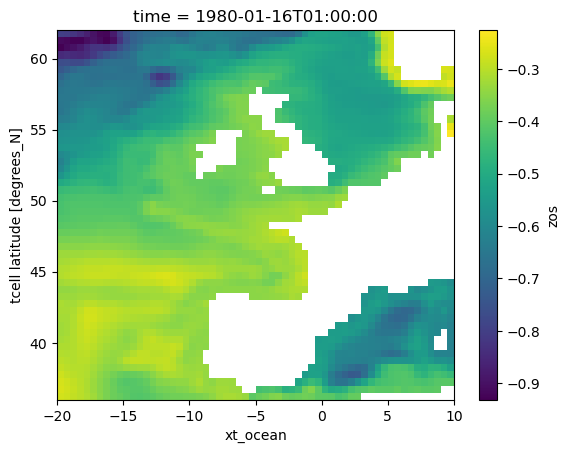

In [15]:
soda_out.zos.isel(time=0).plot()

## Create and save test dataset

In [19]:
soda_test = soda_out.isel(time=range(3))

In [21]:
soda_test.to_netcdf('/projects/0/einf2878/ROMS/data/SODA/forcing_input/soda_test.nc')